In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import networkx as nx
import asyncio
import aiohttp
import matplotlib.pyplot as plt
import powerlaw
from collections import Counter


In [2]:
import os
import json

data_folder_path = '../data/'

all_data = {}
for filename in os.listdir(data_folder_path):
    if filename.endswith(".json"):
        json_file_path = os.path.join(data_folder_path, filename)
        
        with open(json_file_path, 'r') as file:
            all_data[os.path.splitext(filename)[0]] = json.load(file)

In [3]:
def create_character_interaction_graph(data, season=None, characters_info=None):
    graph_dict = {} 
    count = 1  

    if season is None:
        for season_name, episodes_data in data.items():
            for i in range(len(episodes_data)):
                G = nx.Graph()  # Create a new directed graph for each episode
                characters = episodes_data[i]["Characters"]  # Characters from each episode as a list

                # Add nodes from the previous graph (if it exists). 
                if count > 1:
                    G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  # Getting the nodes (characters) from the previous graph (episode)

                    # Add edges and update weights from the previous graph
                    for edge in graph_dict[f'G{count-1}'].edges(data=True):
                        char1, char2, data = edge
                        weight = data.get('weight', 0)
                        G.add_edge(char1, char2, weight=weight)

                # Add new characters as nodes
                if characters is not None: 
                    G.add_nodes_from(characters)  # Adding the characters

                    # Add weighted edges for characters appearing in the same episode
                    for char1 in characters:
                        for char2 in characters:
                            if char1 != char2:
                                if G.has_edge(char1, char2):
                                    G[char1][char2]['weight'] += 1
                                else:
                                    G.add_edge(char1, char2, weight=1)

                graph_dict[f'G{count}'] = G  
                count += 1  
    
    # Same for only one season's data
    else:
        season_data = data[season]  
        graph_dict = {}  
        count = 1  

        for i in range(len(season_data)):
            G = nx.Graph()  
            characters = season_data[i]["Characters"] 

            if count > 1:
                G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  
                
                for edge in graph_dict[f'G{count-1}'].edges(data=True):
                    char1, char2, data = edge
                    weight = data.get('weight', 0)
                    G.add_edge(char1, char2, weight=weight)

            if characters is not None:  
                G.add_nodes_from(characters) 

                for char1 in characters:
                    for char2 in characters:
                        if char1 != char2:
                            if G.has_edge(char1, char2):
                                G[char1][char2]['weight'] += 1
                            else:
                                G.add_edge(char1, char2, weight=1)

            graph_dict[f'G{count}'] = G  
            count += 1 

    # Add node attributes to all graphs
    if characters_info:
        for key, graph in graph_dict.items():
            add_node_attributes(graph, characters_info)

    return graph_dict

# Adding the note attributes from the characters' infobox.
def add_node_attributes(graph, attributes_dict):
    for node, attributes in attributes_dict.items():
        normalized_node = next((n for n in graph.nodes if node.lower() == n.lower()), None)
        
        if normalized_node:
            graph.nodes[normalized_node].update(attributes)

In [22]:
def filter_edges_below_threshold(cumulative_graph, final_graph, threshold):

    filtered_graph = cumulative_graph.copy()

    edges_to_remove = [(u, v) for u, v, w in cumulative_graph.edges(data='weight') if final_graph[u][v]['weight'] < threshold]
    filtered_graph.remove_edges_from(edges_to_remove)

    isolated_nodes = [node for node in filtered_graph.nodes() if filtered_graph.degree(node) == 0]
    filtered_graph.remove_nodes_from(isolated_nodes)

    return filtered_graph

In [4]:
# The dictionary of the 1013 graphs of all the episodes with the characters as nodes. Attributes are added from their infobox on the fandom page.
graph_dict_all_seasons = create_character_interaction_graph(all_data["episodes_seasons_characters"], characters_info=all_data['characters_infobox'])

In [5]:
# The five great nations
five_great_node_dict = {
    "Konohagakure": "red", 
    "Sunagakure": "green",      
    "Kirigakure": "blue",
    "Kumogakure": "yellow",
    "Iwagakure": "#8B4513",
    "default": "black"
}

five_great_edges_dict = {
    "Konohagakure-Konohagakure": "red", 
    "Sunagakure-Sunagakure": "green", 
    "Kirigakure-Kirigakure": "blue", 
    "Kumogakure-Kumogakure": "yellow",
    "Iwagakure-Iwagakure": "#8B4513",
    "default": "gray"
}

id_color_dict = {"Konohagakure": "Red", "Sunagakure": "Green", "Kirigakure": "Blue", "Kumogakure": "Yellow", "Iwagakure": "Brown", "Remaining villages": "Black"}


In [20]:
def color_nodes_by_affiliation(G, node_colors_dict):
    """
    Color nodes in the graph based on their affiliation.

    Parameters:
    - G: NetworkX graph
    - node_colors_dict: Dictionary mapping village names to colors

    Returns:
    - List of node colors
    """
    node_colors = []
    for node in G.nodes:
        affiliation = G.nodes[node].get('Affiliation', [])

        if affiliation:
            for village in affiliation:
                if village in node_colors_dict:
                    node_colors.append(node_colors_dict[village])
                    break  # Stop checking other villages for this node
            else:
                node_colors.append(node_colors_dict["default"])  # Assign default color if no matching village is found
        else:
            node_colors.append(node_colors_dict["default"])

    return node_colors


def color_edges_by_affiliation(G, edge_colors_dict):
    """
    Color edges in the graph based on the affiliation of their nodes.

    Parameters:
    - G: NetworkX graph
    - edge_colors_dict: Dictionary mapping village names to edge colors

    Returns:
    - List of edge colors
    """
    edge_colors = []
    for edge in G.edges:
        node1, node2 = edge
        affiliation1 = G.nodes[node1].get('Affiliation', [])
        affiliation2 = G.nodes[node2].get('Affiliation', [])

        # Check if both nodes have affiliation
        if affiliation1 and affiliation2:
            common_affiliation = set(affiliation1) & set(affiliation2)
            if common_affiliation:
                for village in common_affiliation:
                    edge_key = f"{village}-{village}"
                    if edge_key in edge_colors_dict:
                        edge_colors.append(edge_colors_dict[edge_key])
                        break  # Stop checking other villages for this edge
                else:
                    edge_colors.append(edge_colors_dict["default"])  # Assign default color if no matching village is found
            else:
                edge_colors.append(edge_colors_dict["default"])  # Assign default color if no common affiliation
        else:
            edge_colors.append(edge_colors_dict["default"])  # Assign default color if one or both nodes have no affiliation

    return edge_colors

In [55]:
def plot_graph(graph, layout='spring', figsize=(12, 18), with_labels=True):
    # Calculate node degrees
    node_degrees = dict(graph.degree())

    # Scale node sizes based on degrees
    node_sizes = [deg * 10 for deg in node_degrees.values()]  # Adjust the multiplier as needed for desired size

    # Get node and edge colors
    node_colors = color_nodes_by_affiliation(graph, five_great_node_dict)
    edge_colors = color_edges_by_affiliation(graph, five_great_edges_dict)

    if layout=='spring':
        pos = nx.spring_layout(graph, scale=8.0) 
    elif layout=='kamada-kawai':
        pos= nx.kamada_kawai_layout(graph)
    elif layout=='spectral':
        pos = nx.spectral_layout(graph)

    # Plot the graph
    plt.figure(figsize=figsize)
    nx.draw(graph, pos, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, width=0.1, with_labels=with_labels)

    plt.show()

### Development of the Series w.r.t. a fixed Threshold

In [41]:
episode_graphs_list = ['G1', 'G20', 'G100', 'G220', 'G600', 'G1013']
threshold = 100

filtered_graphs = {}
for episode in episode_graphs_list:
    filtered_graphs[episode] = filter_edges_below_threshold(graph_dict_all_seasons[episode], graph_dict_all_seasons['G1013'], threshold)

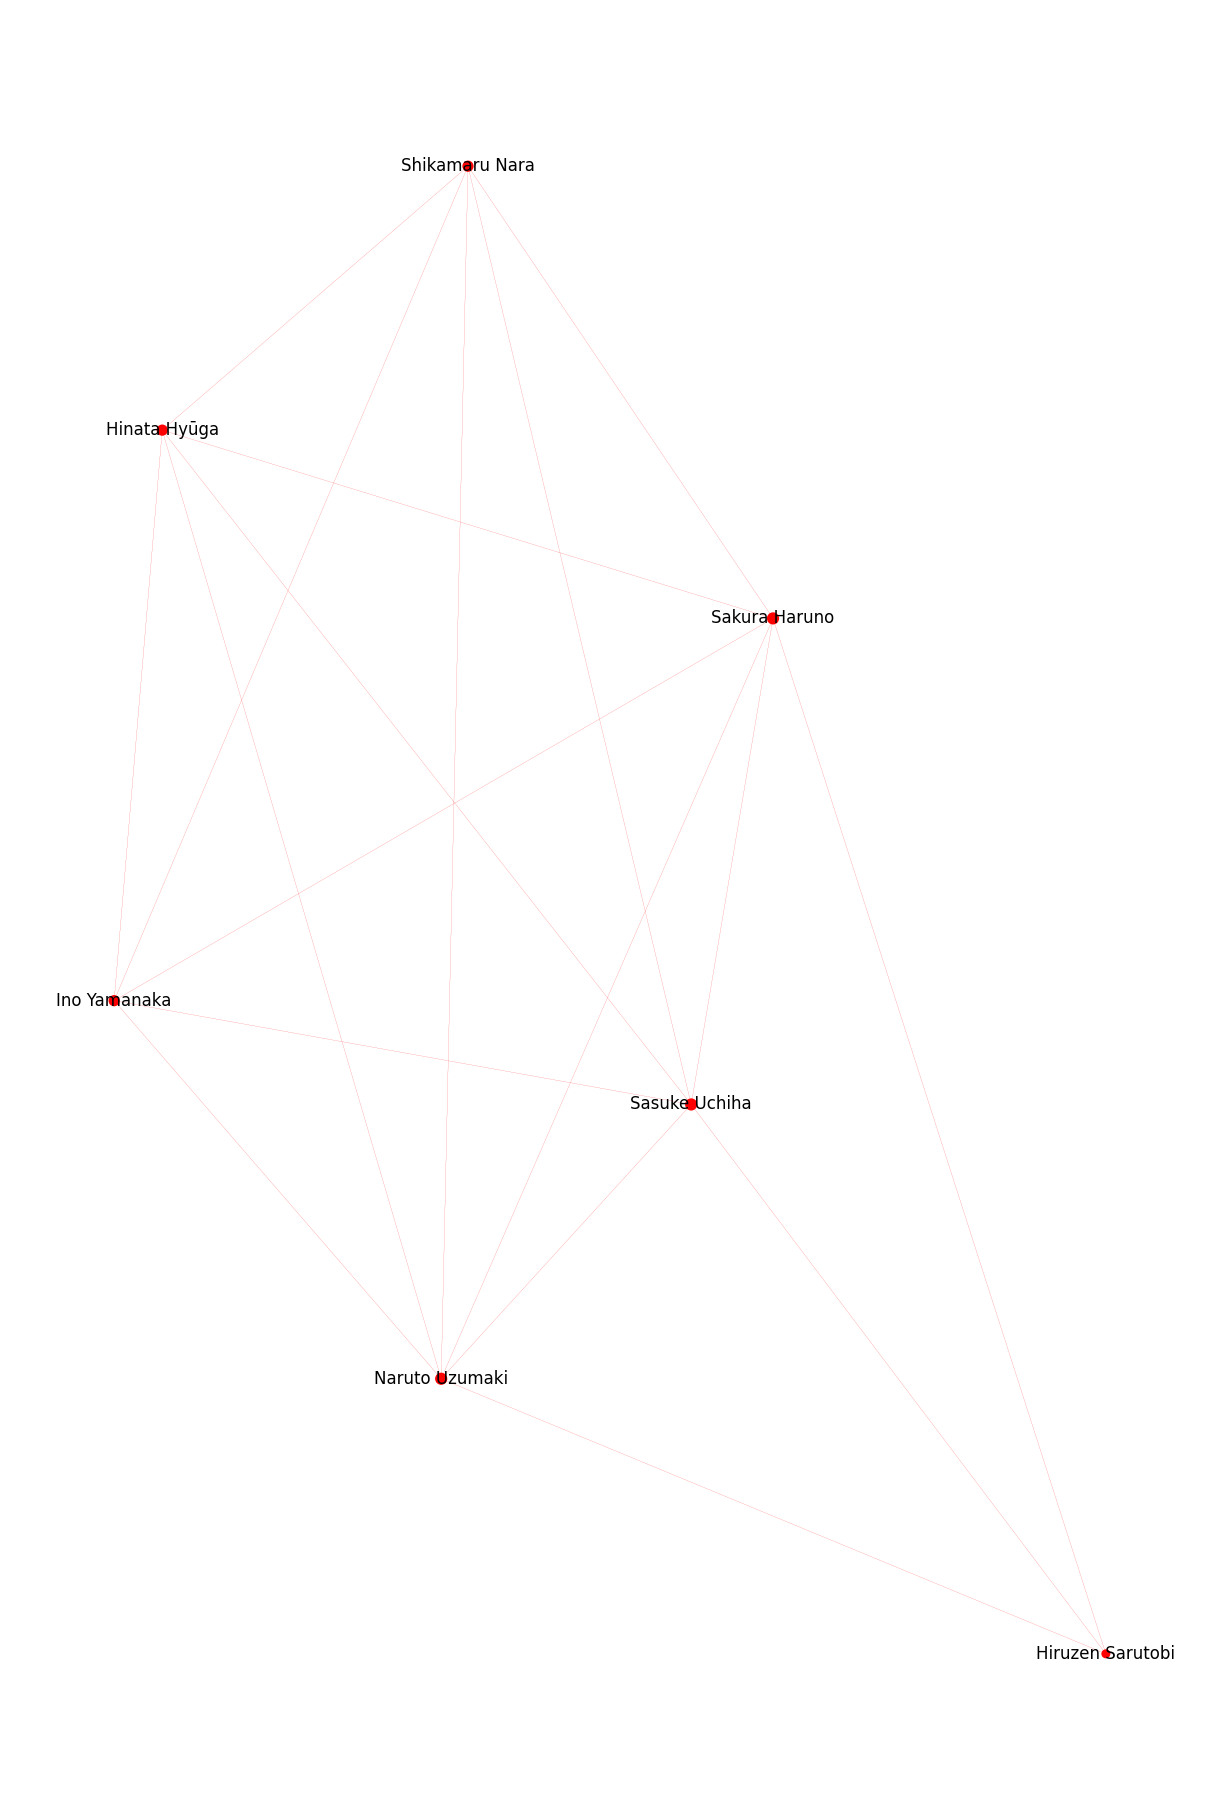

In [42]:
plot_graph(filtered_graphs['G1'])

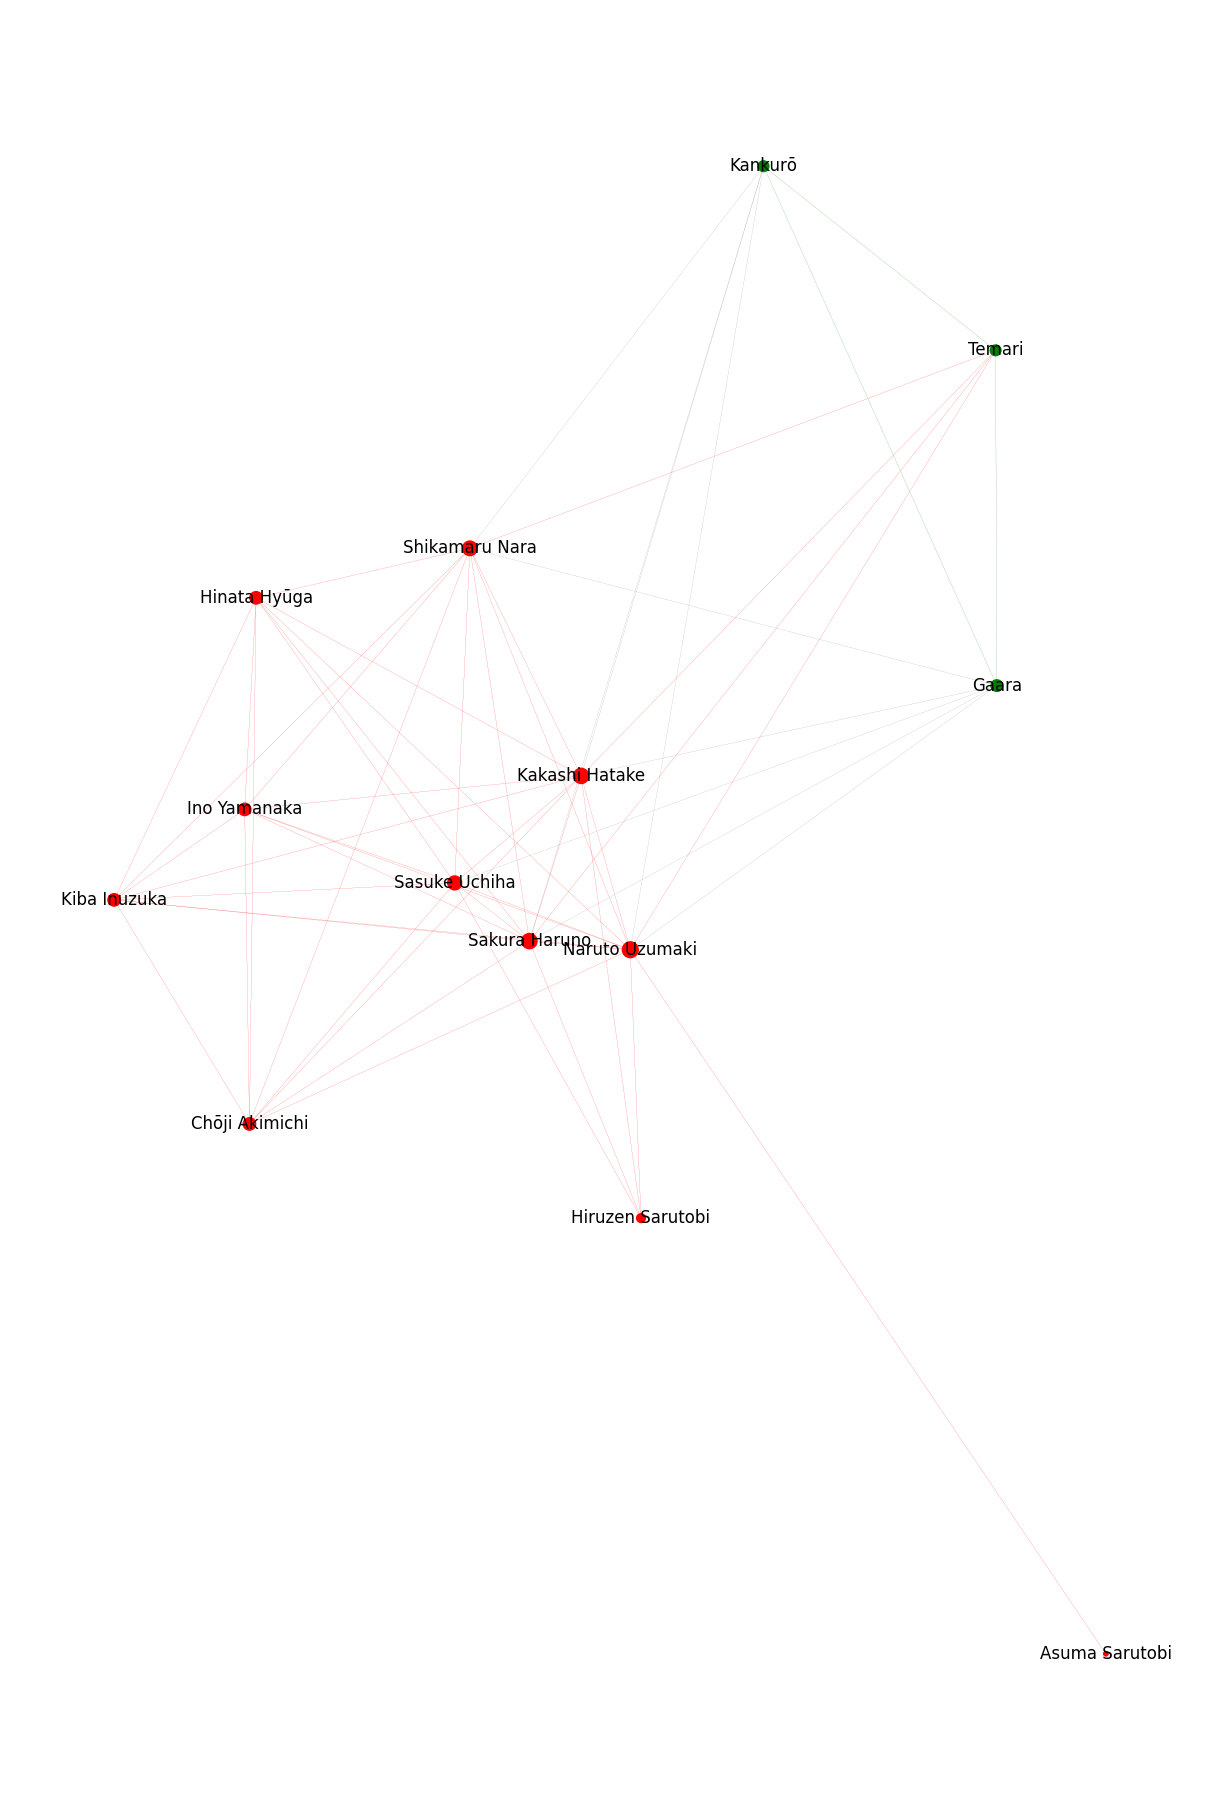

In [43]:
plot_graph(filtered_graphs['G20'])

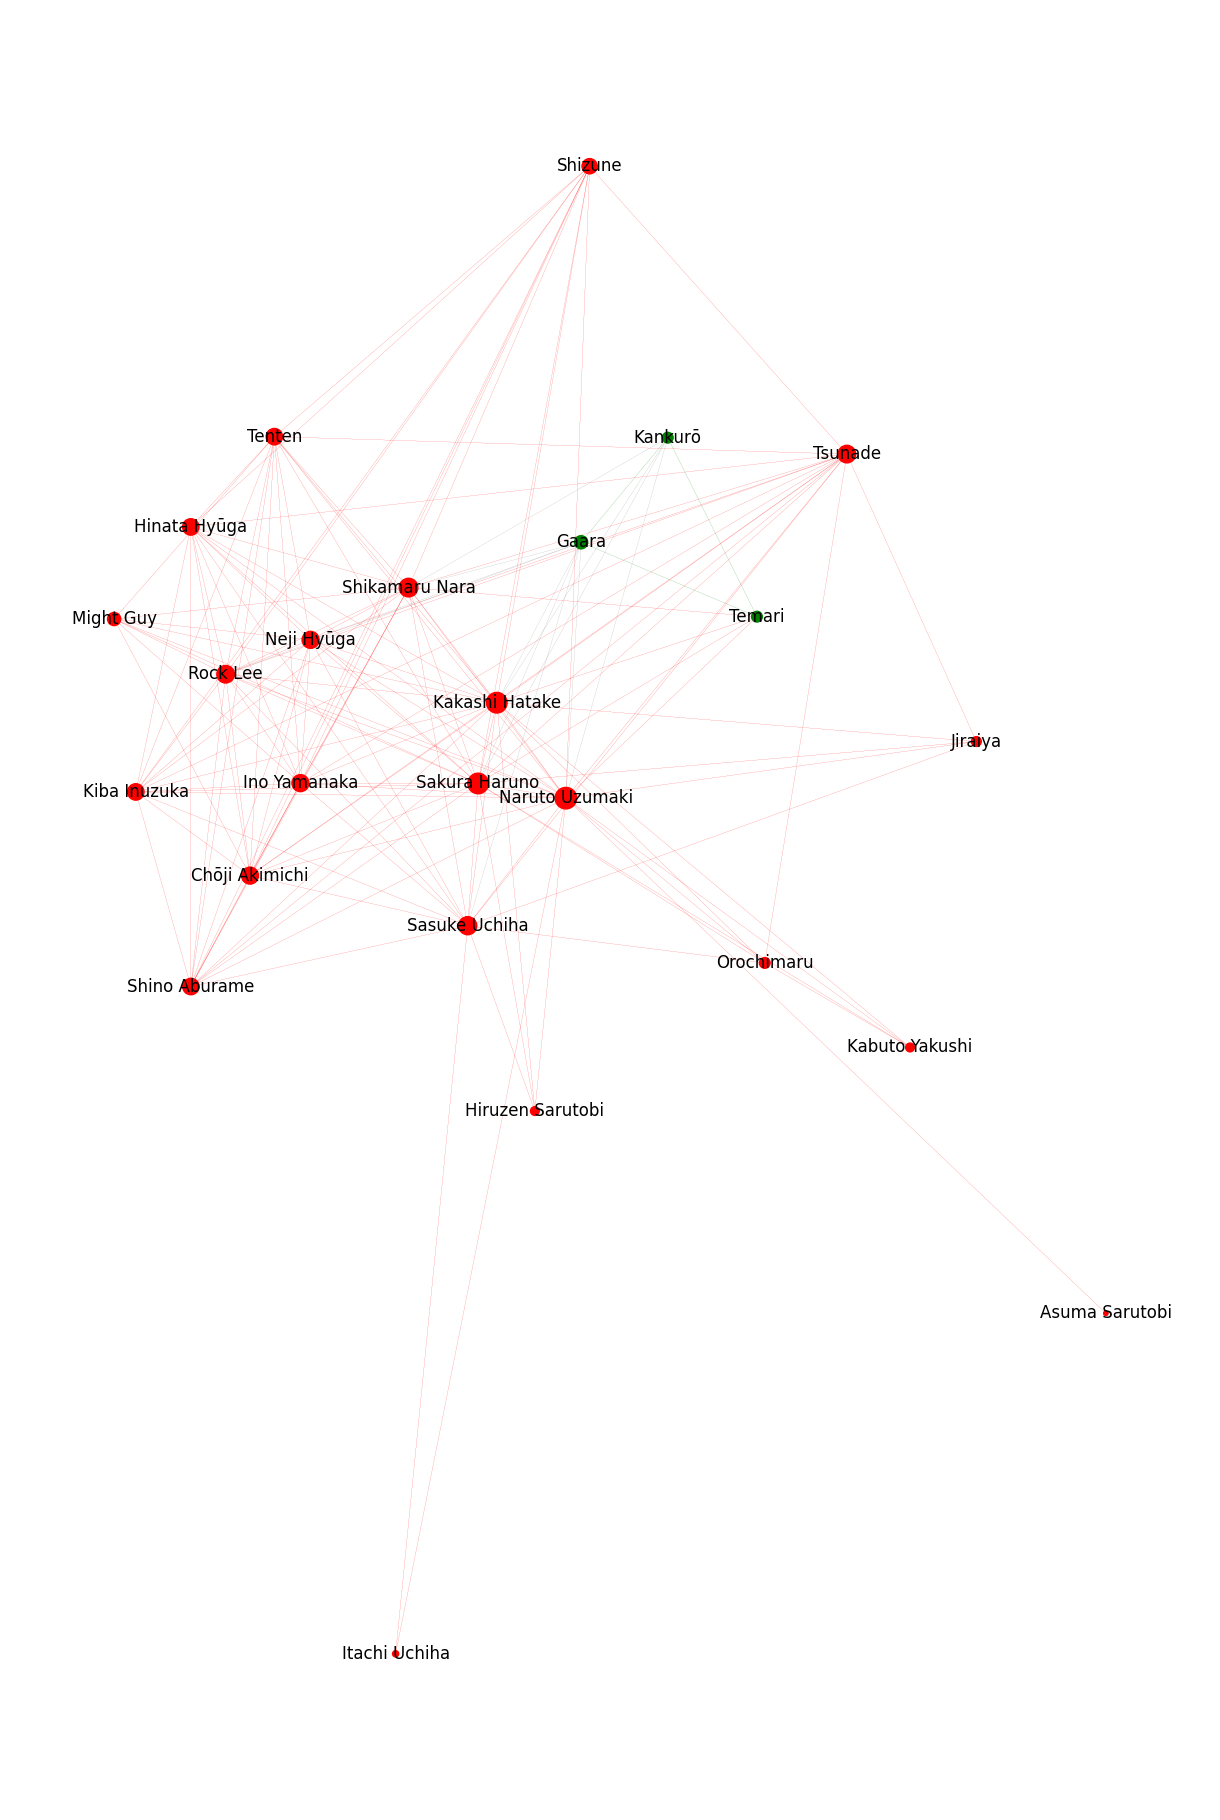

In [44]:
plot_graph(filtered_graphs['G100'])

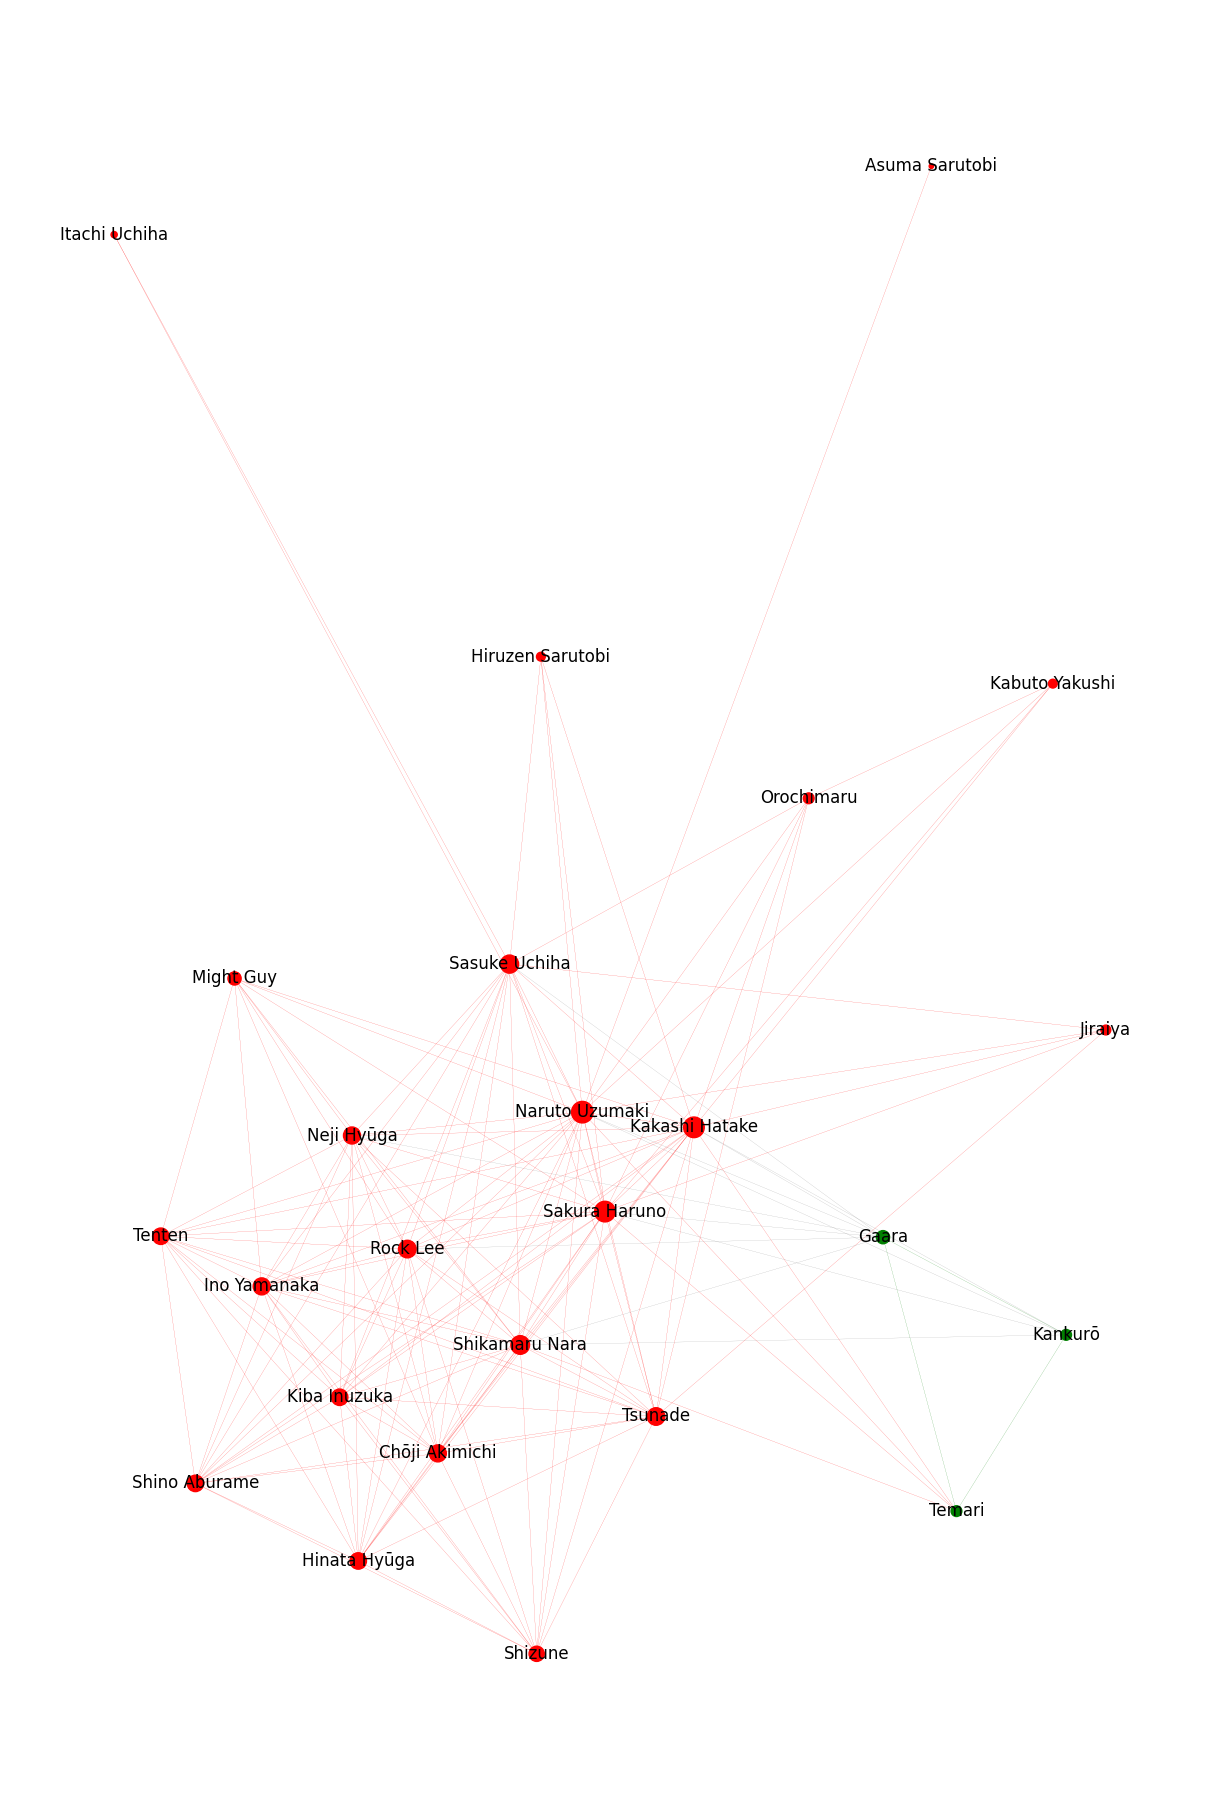

In [45]:
plot_graph(filtered_graphs['G220'])

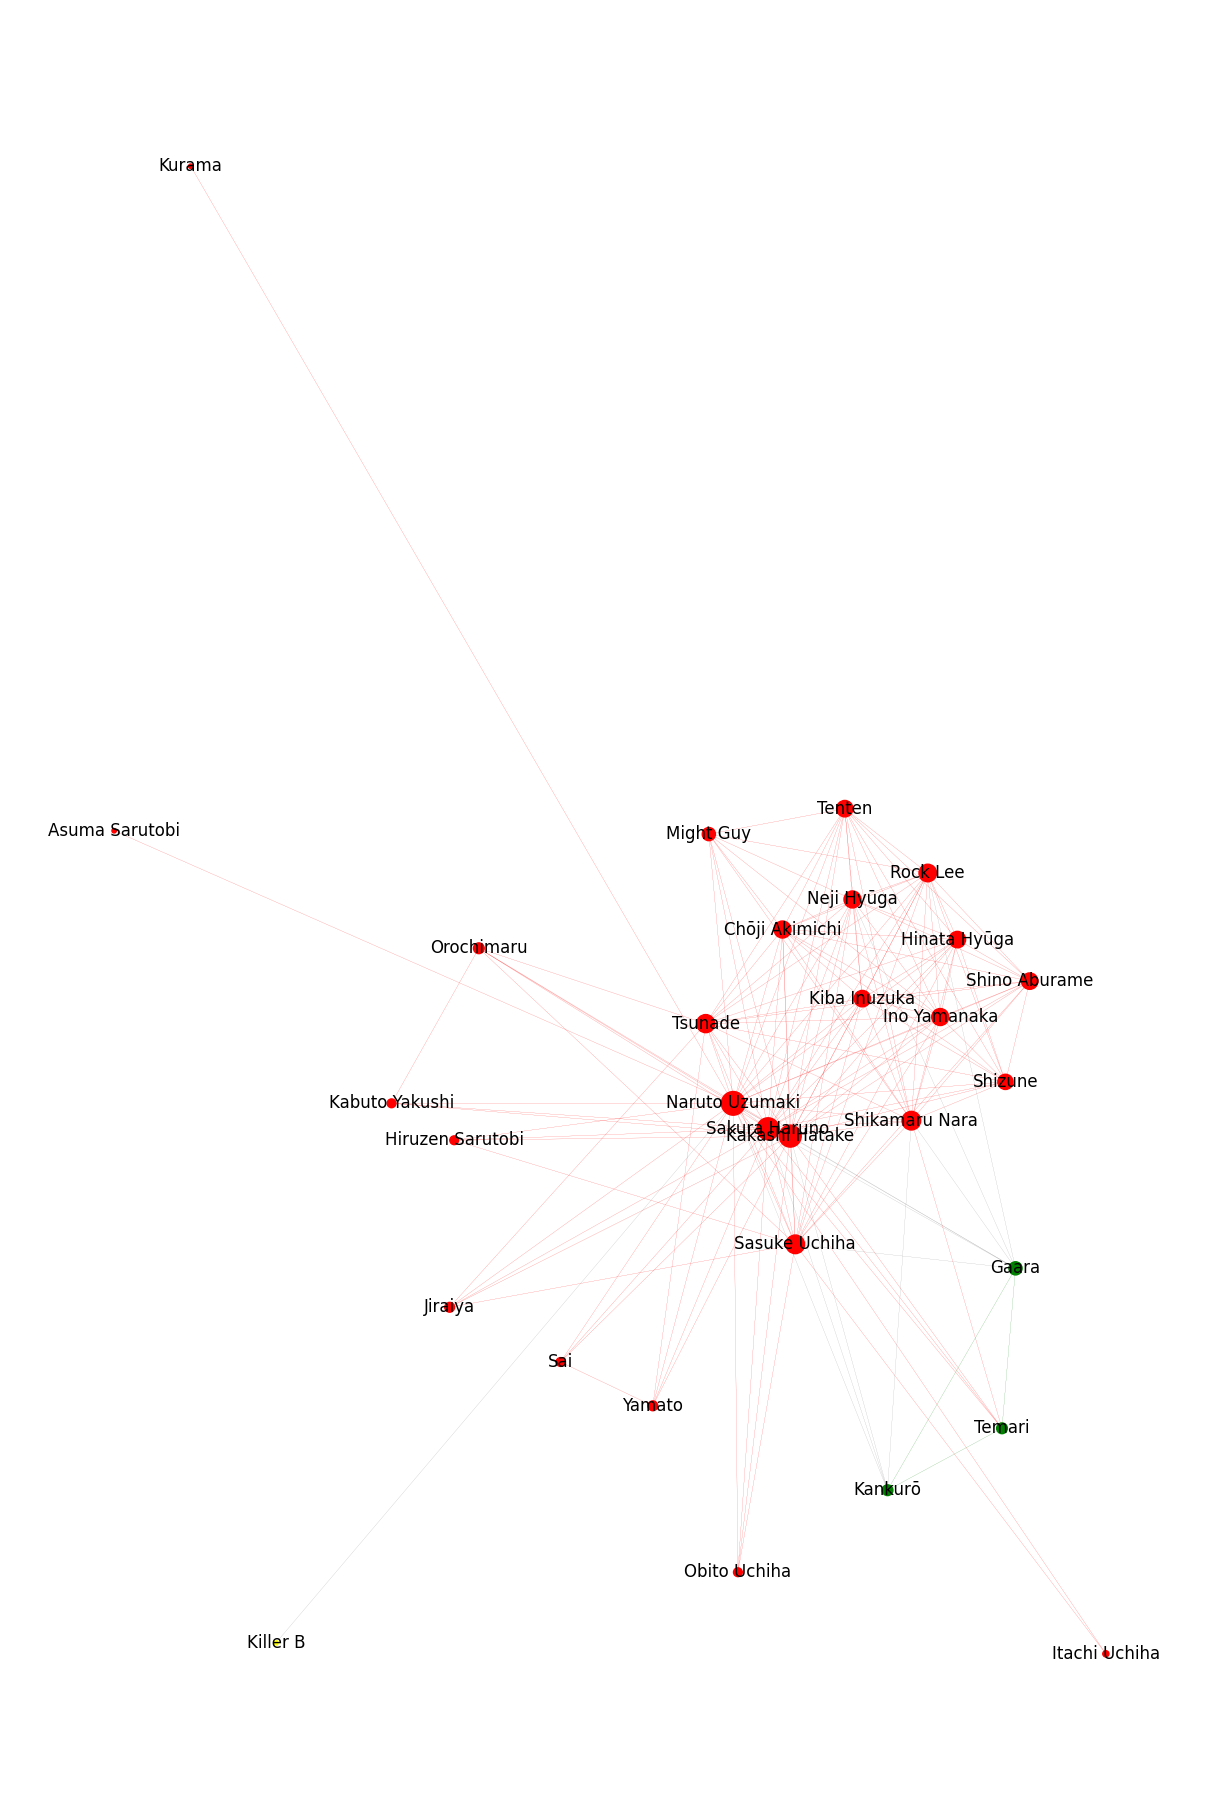

In [46]:
plot_graph(filtered_graphs['G600'])

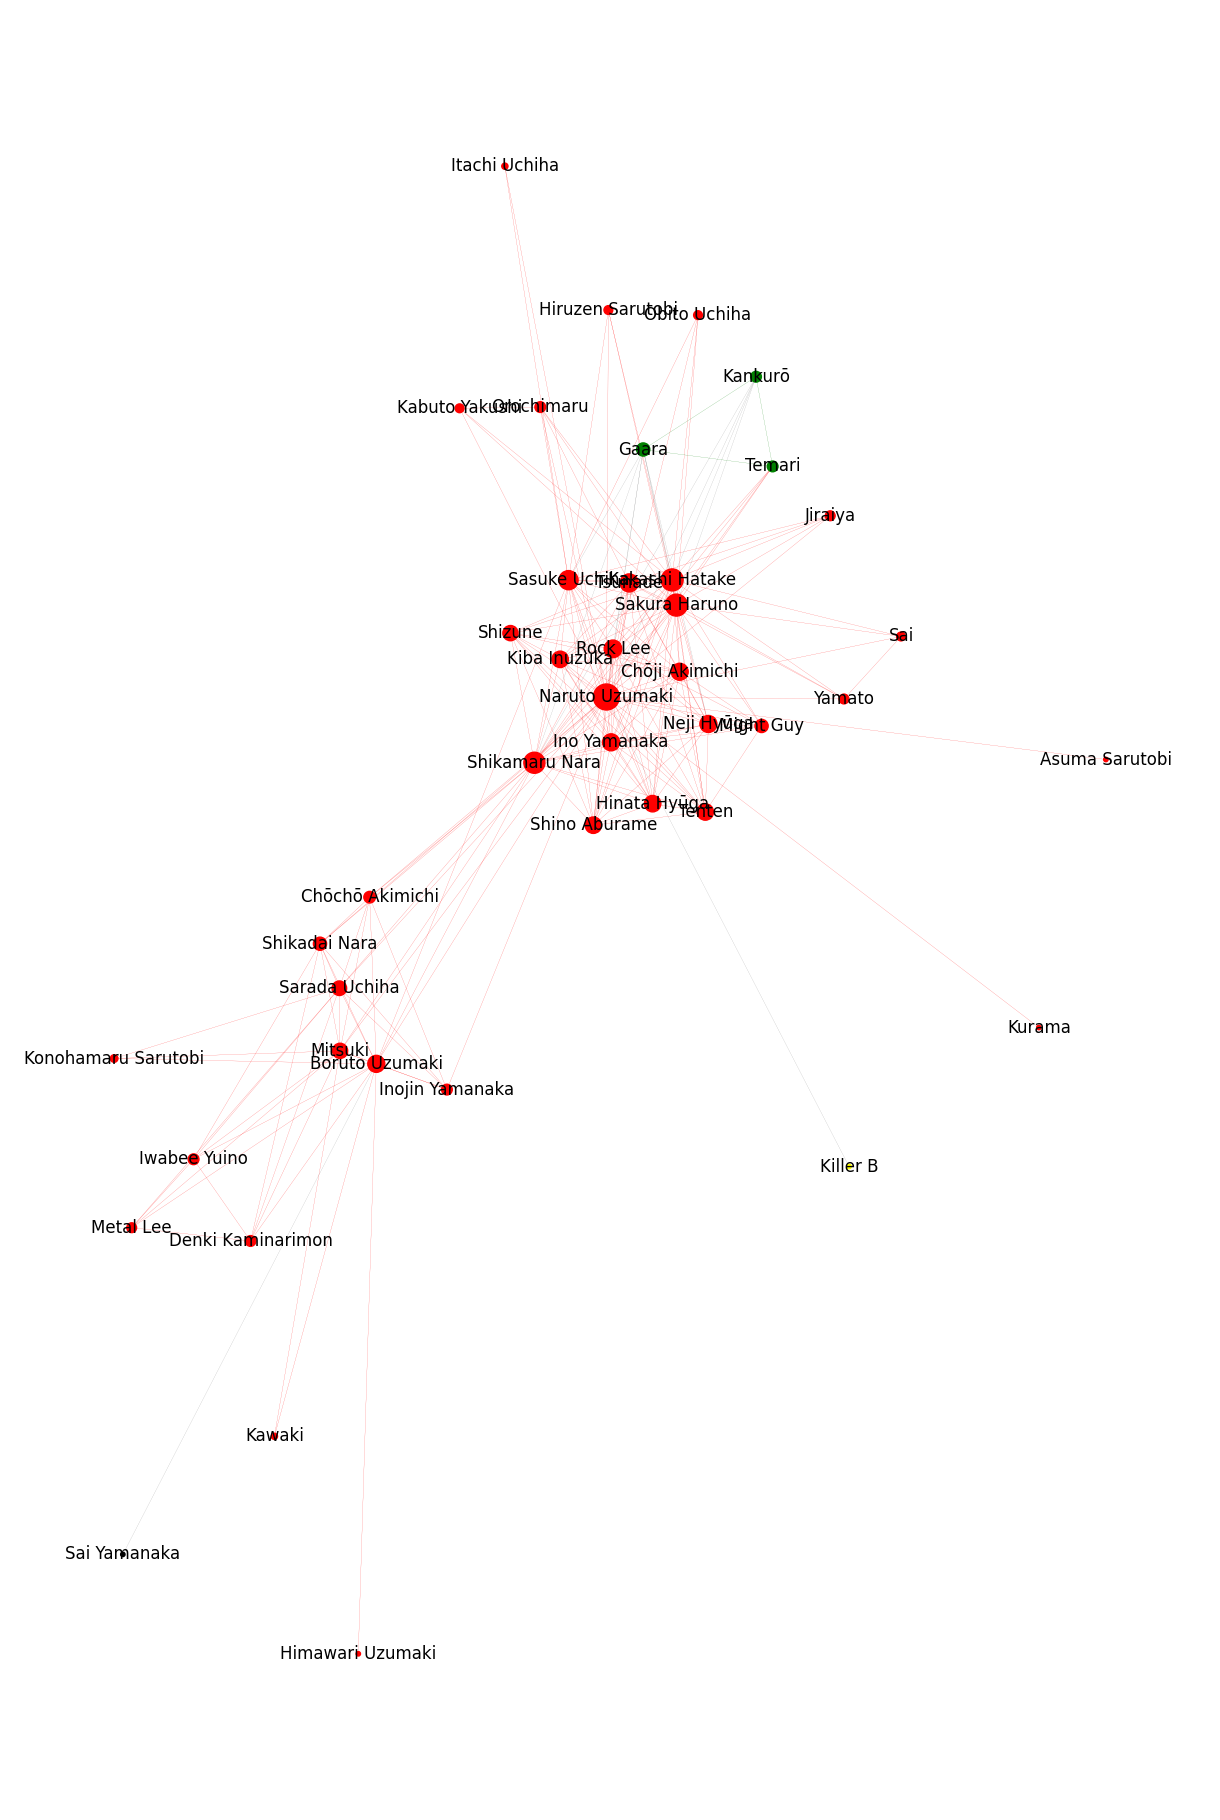

In [47]:
plot_graph(filtered_graphs['G1013'])

### Analysis of the Complete Network w.r.t. Changing Thresholds

In [48]:
G1013 = graph_dict_all_seasons['G1013']
thresholds = [10, 50, 100, 200, 500]

filtered_complete_graph = {}
for threshold in thresholds:
    filtered_complete_graph[f"Min Co-occurence: {threshold}"] = filter_edges_below_threshold(G1013, G1013, threshold)

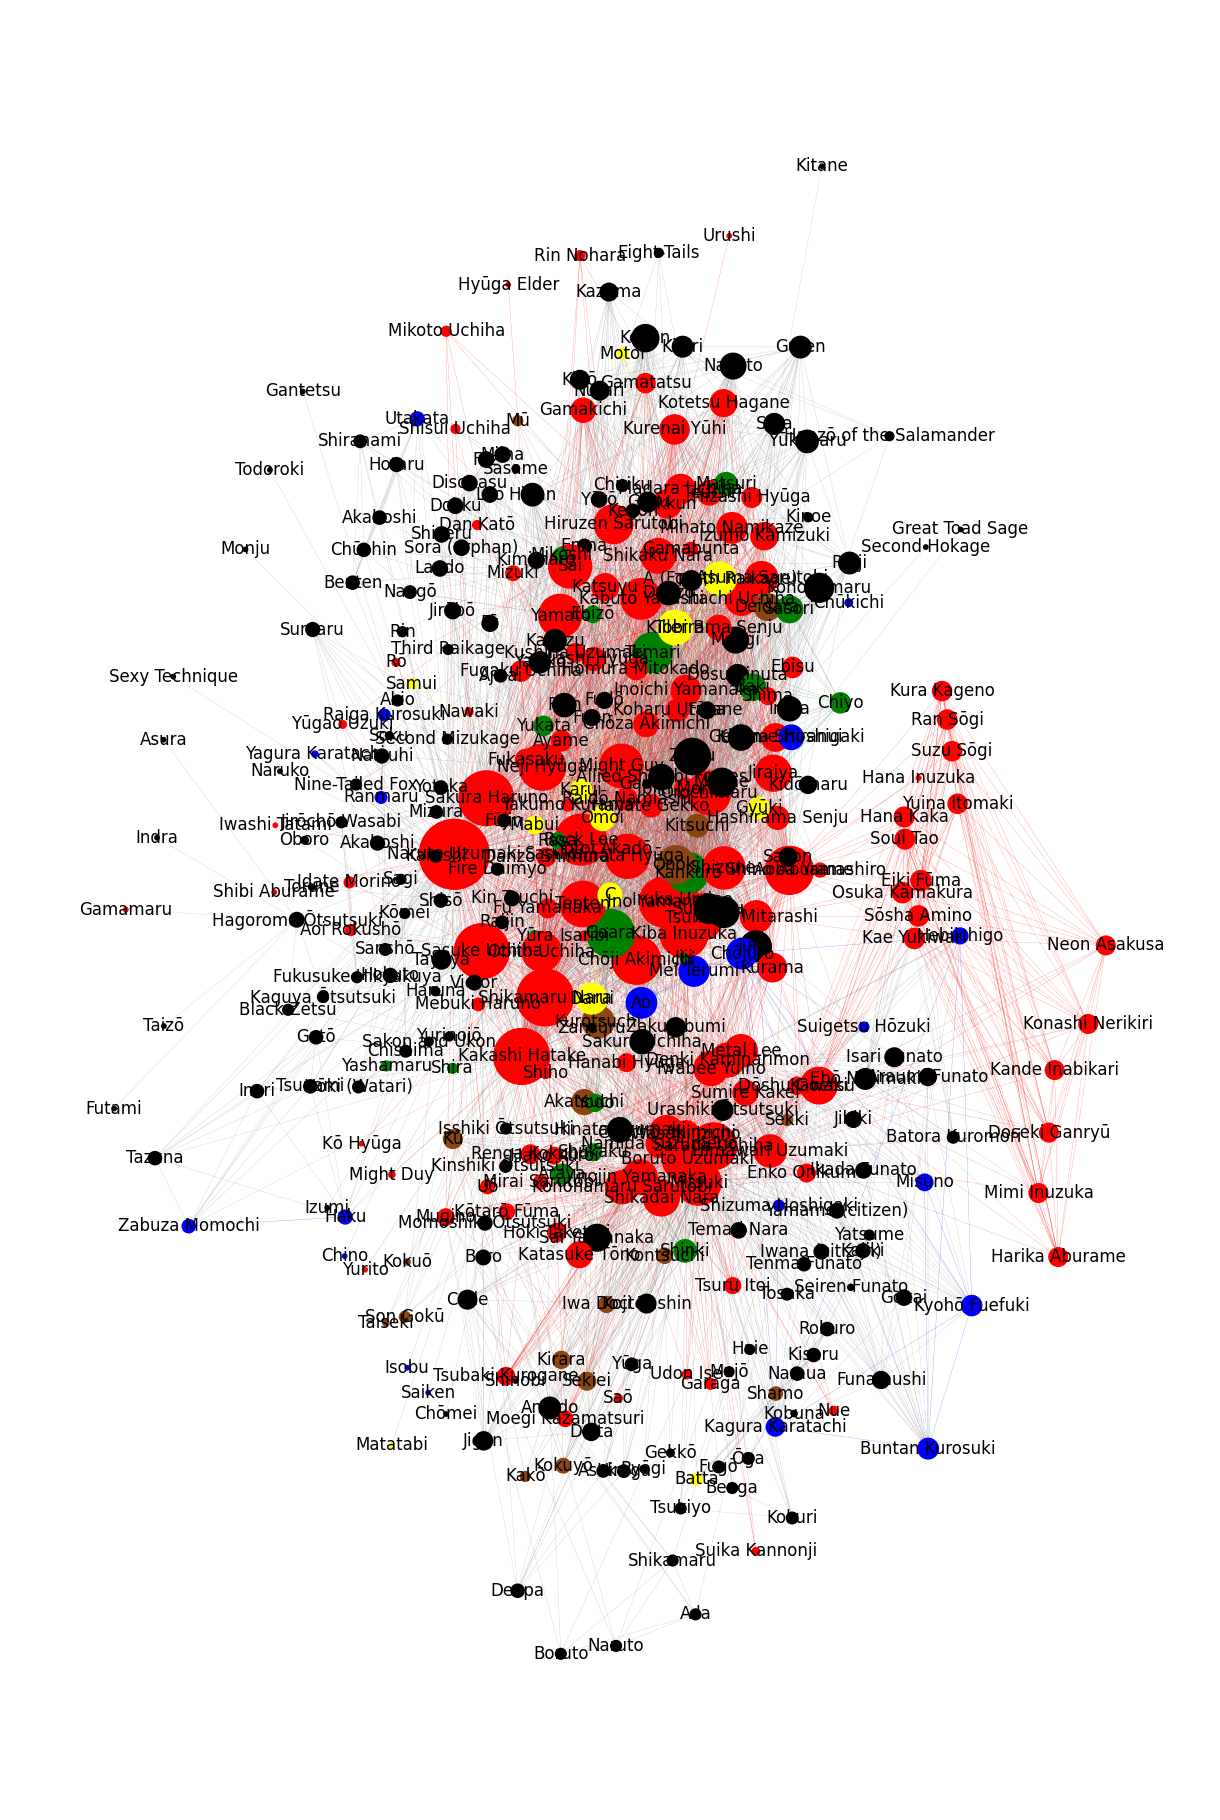

In [58]:
plot_graph(filtered_complete_graph['Min Co-occurence: 10'], layout='kamada-kawai')

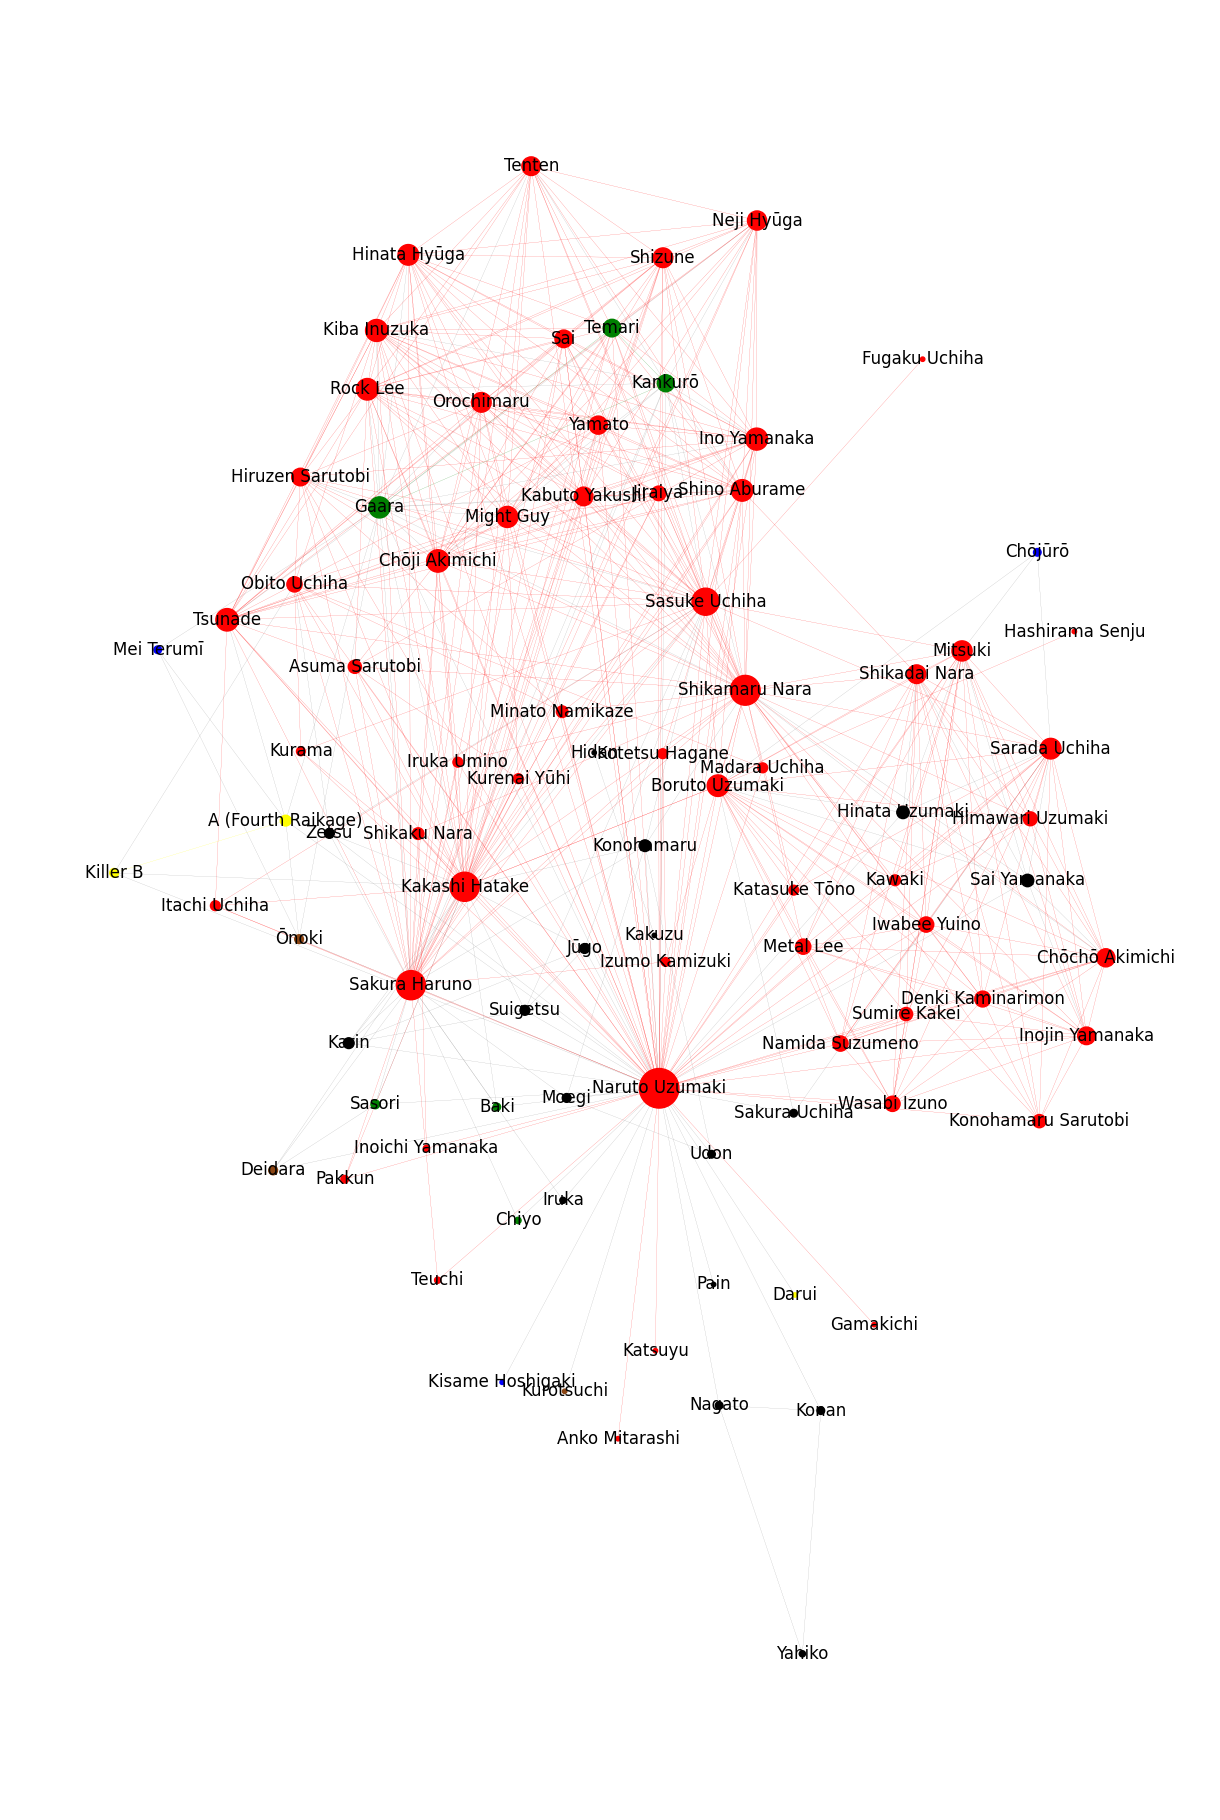

In [57]:
plot_graph(filtered_complete_graph['Min Co-occurence: 50'], layout='kamada-kawai')

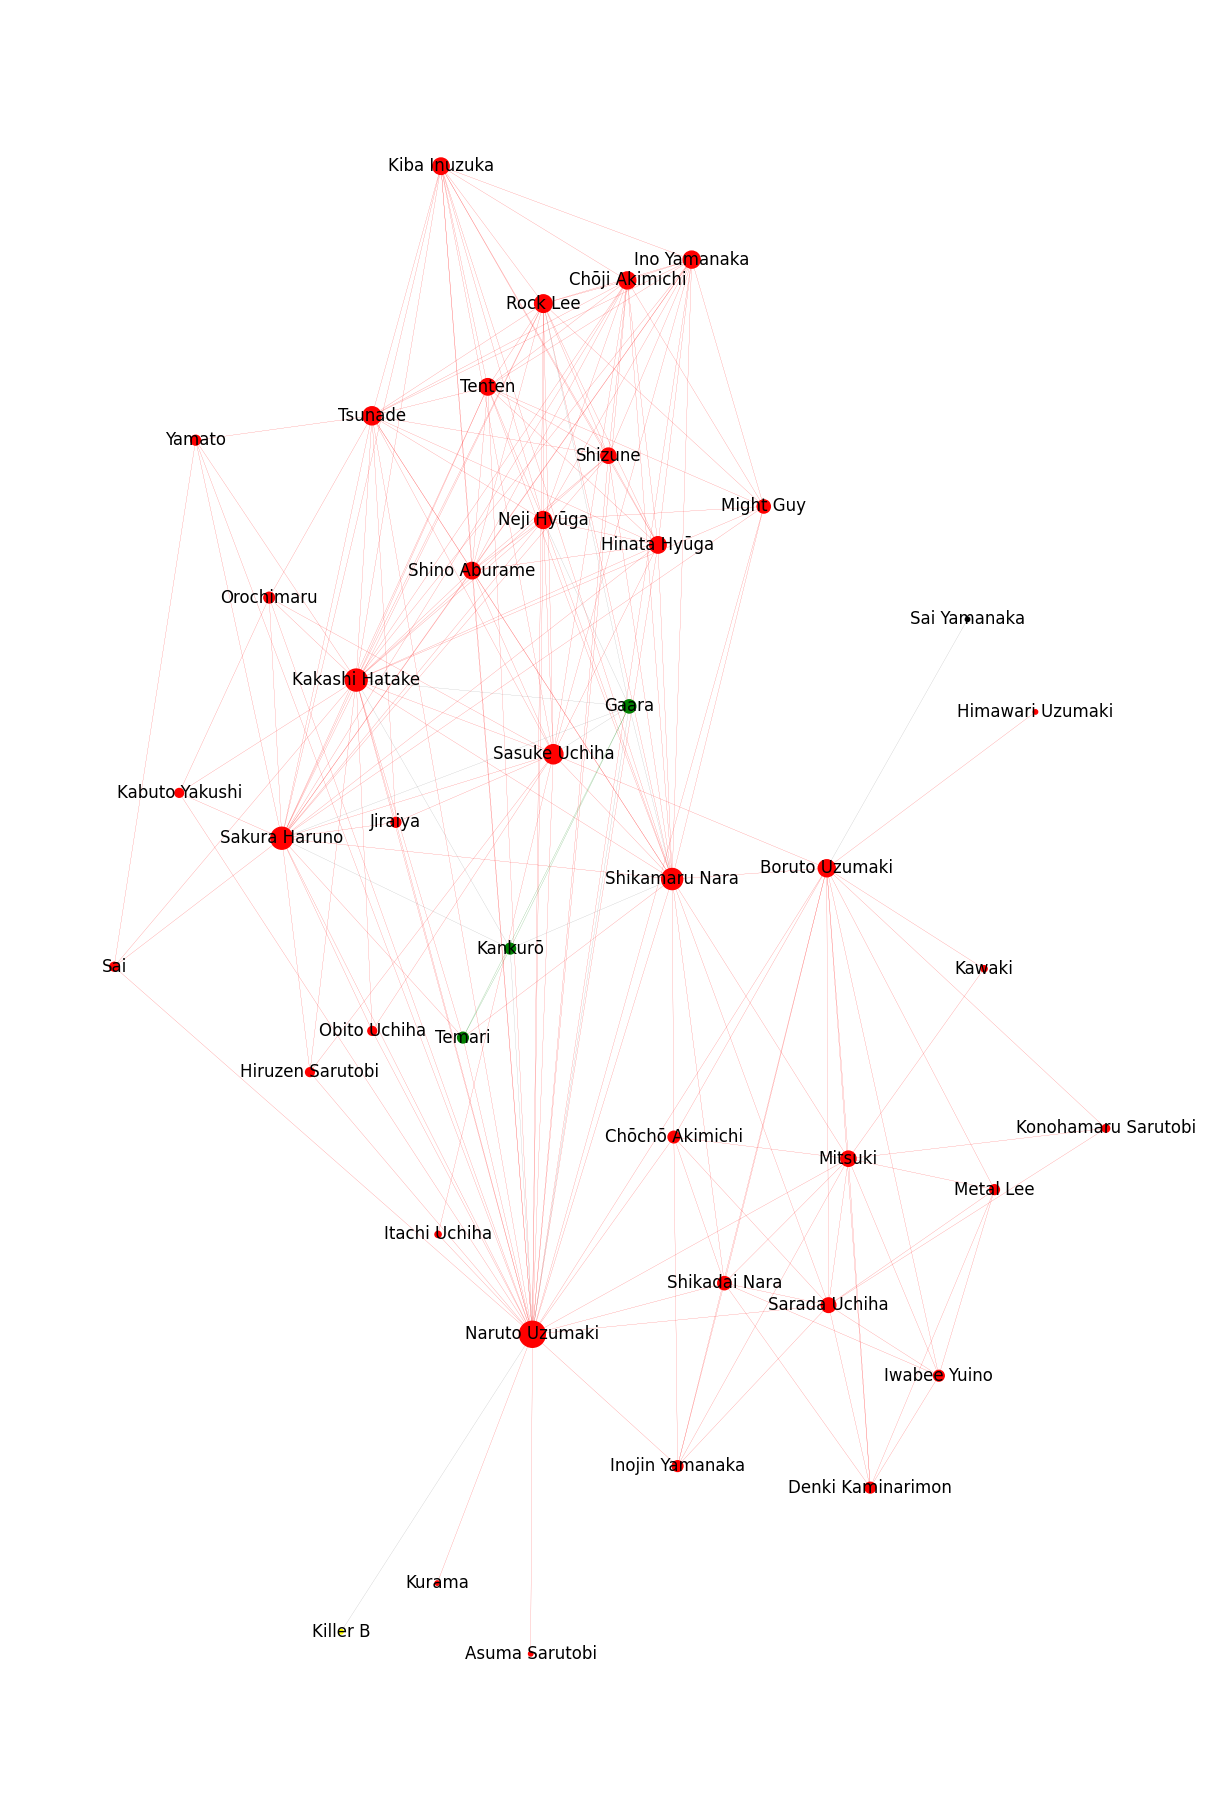

In [59]:
plot_graph(filtered_complete_graph['Min Co-occurence: 100'], layout='kamada-kawai')

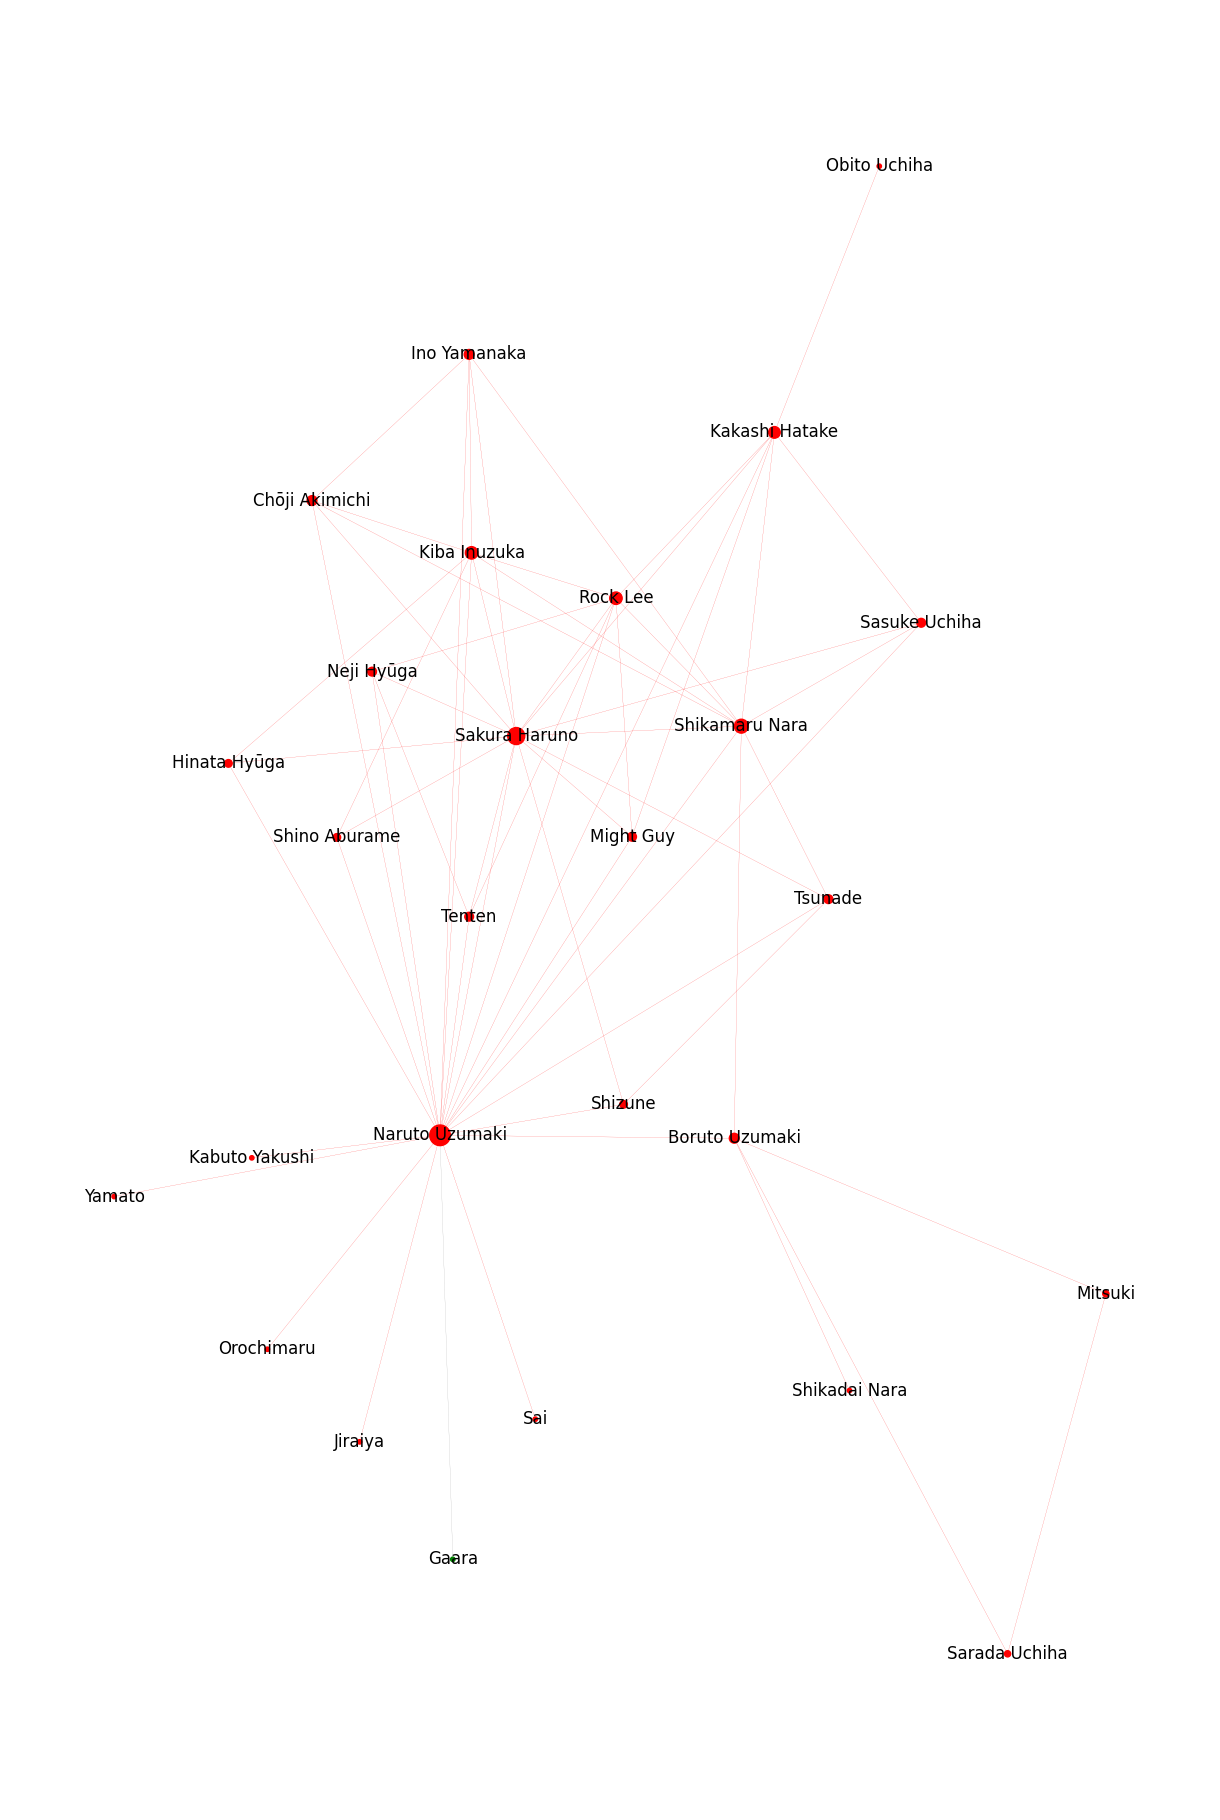

In [60]:
plot_graph(filtered_complete_graph['Min Co-occurence: 200'], layout='kamada-kawai')

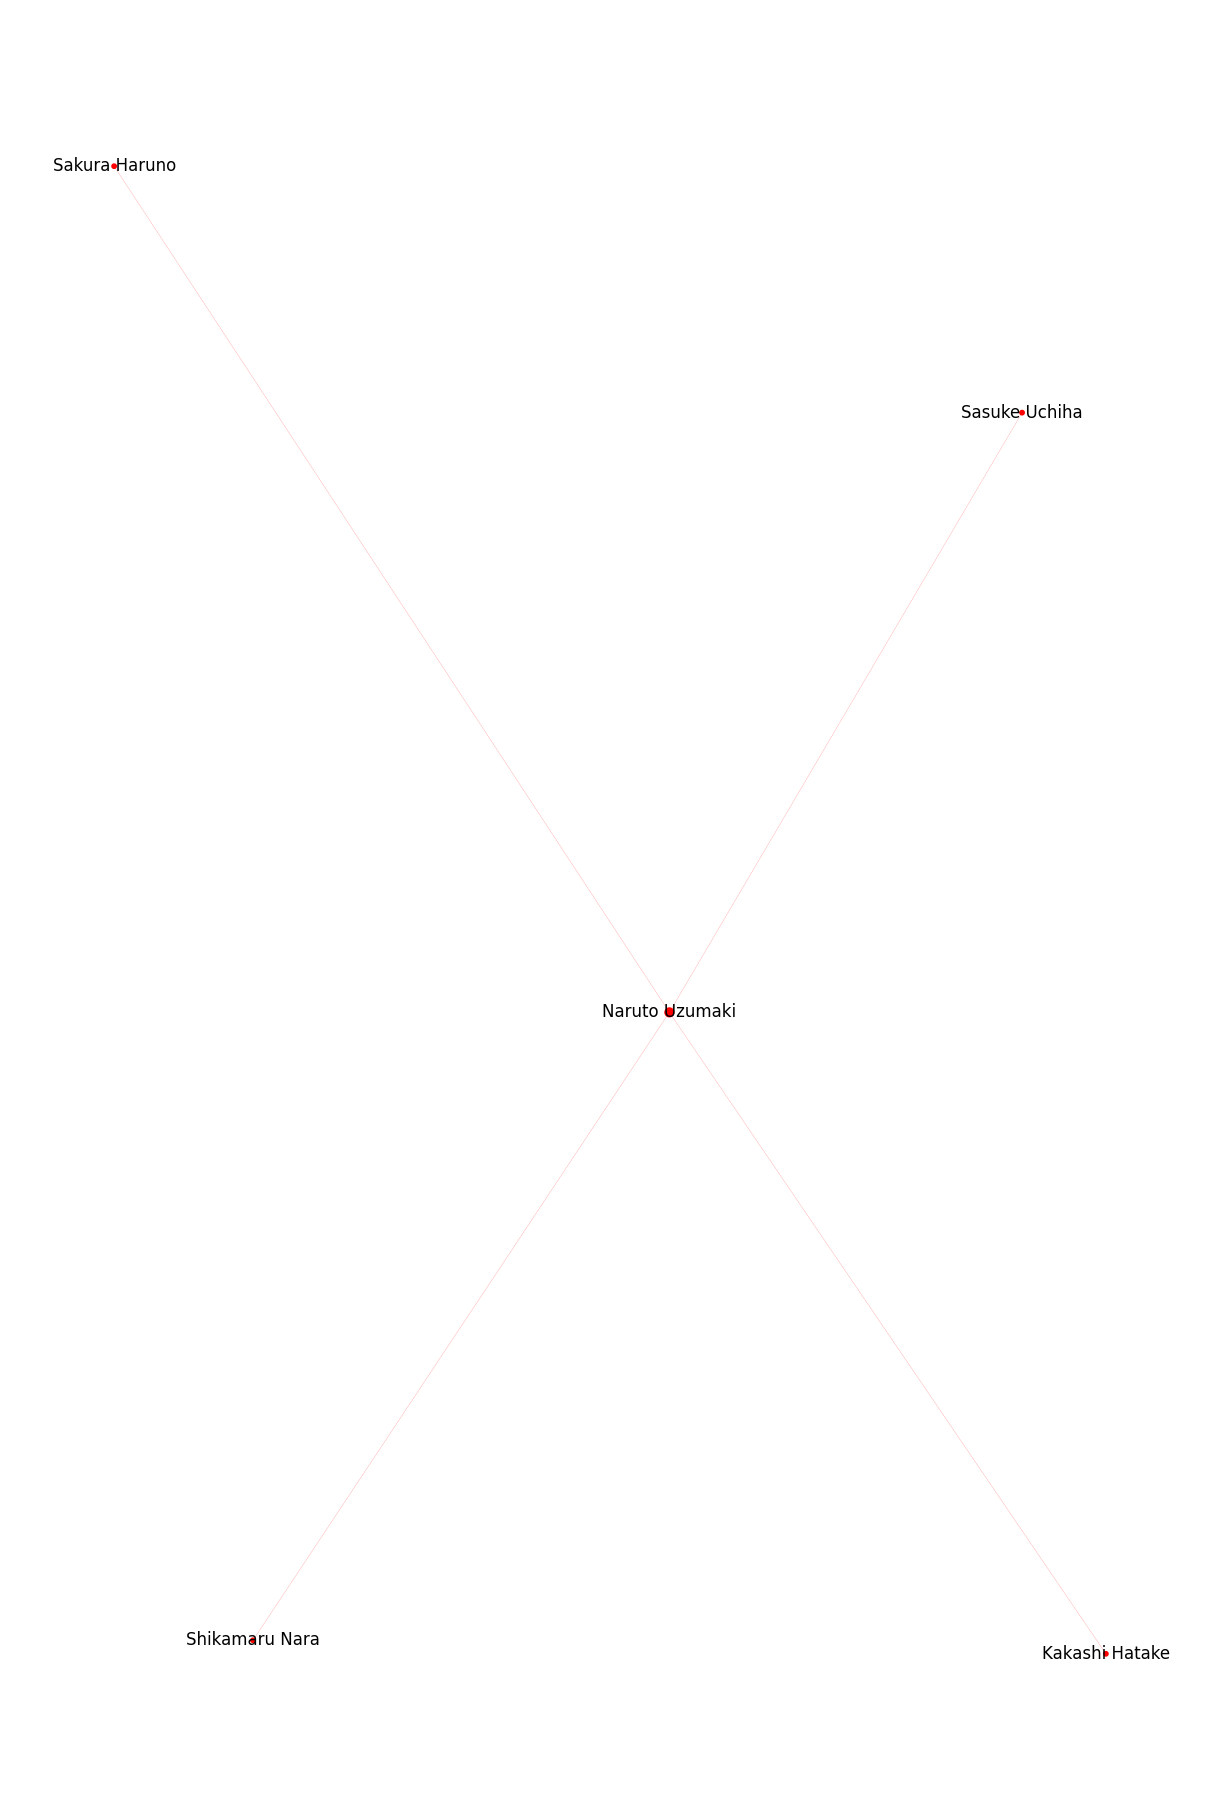

In [61]:
plot_graph(filtered_complete_graph['Min Co-occurence: 500'], layout='kamada-kawai')